# Use Toplez Matrix to turn the 2D convolution into matrix multiplication

In [1]:
import torch
import torch.nn.functional as F
import numpy as np

import scipy.linalg as linalg
import PIL.Image as Image
import matplotlib.pyplot as plt

In [2]:
# Convolution is equivalent with Unfold + Matrix Multiplication + Fold (or view to output shape)
inp = torch.randn(1, 3, 10, 12)
w = torch.randn(2, 3, 4, 5)
inp_unf = torch.nn.functional.unfold(inp, (4, 5))
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = out_unf.view(1, 2, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()

tensor(5.7220e-06)

# Try to understand how it works

In [3]:
print(inp_unf.shape, w.view(w.size(0), -1).t().shape)

torch.Size([1, 60, 56]) torch.Size([60, 2])


## Generate specific matrix for convolution

In [4]:
inp = np.arange(1,121)
w = np.arange(1,21)
inp = torch.from_numpy(inp).float().view(1, 1, 10, 12)
print("original input:\n", inp.data)
w = torch.from_numpy(w).float().view(1, 1, 4, 5)
#print(inp)
unfolded = torch.nn.functional.unfold(inp, (4, 5), padding=0, stride=1)
print("\nshape after unfold: ", unfolded.shape)
print(f"{unfolded.shape[1]} is the block size, {unfolded.shape[2]} is the number of blocks\n")
print("Let's slice and see one block, then it makes total sense, unfolded[0,:,0] is:\n", unfolded[0, :,0])
print("\nreshape the slice into block shape: \n", unfolded[0, :,0].reshape(4,5))

original input:
 tensor([[[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
            12.],
          [ 13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
            24.],
          [ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
            36.],
          [ 37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
            48.],
          [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
            60.],
          [ 61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
            72.],
          [ 73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
            84.],
          [ 85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
            96.],
          [ 97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
           108.],
          [109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
           120.]]]])

shape after unfold:  torch.Si

In [5]:
print(w)

tensor([[[[ 1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10.],
          [11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20.]]]])


# Explanation

The unfold function returns a tensor with size: $(N,C\times\Pi(\text{kernel size}),L)$ where $C\times\Pi(\text{kernel size})$ is the block size, and $L$ is the total number of such blocks.

Therefore we flatten the kernel into a 1D tensor, and then use the transposed version (expose each block) of unfolded tensor, then multiply it with the flattened kernel tensor.

In [6]:
out_unf = unfolded.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = out_unf.view(1, 1, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()

tensor(0.)

# Multi-Channel Convolution as Matrix Multiplication

In [79]:
def toeplitz_1_ch(kernel, input_size):
    # shapes
    k_h, k_w = kernel.shape
    i_h, i_w = input_size
    o_h, o_w = i_h-k_h+1, i_w-k_w+1

    # construct 1d conv toeplitz matrices for each row of the kernel
    toeplitz = []
    for r in range(k_h):
        toeplitz.append(linalg.toeplitz(c=(kernel[r,0], *np.zeros(i_w-k_w)), r=(*kernel[r], *np.zeros(i_w-k_w))))

    # construct toeplitz matrix of toeplitz matrices (just for padding=0)
    h_blocks, w_blocks = o_h, i_h
    h_block, w_block = toeplitz[0].shape

    W_conv = np.zeros((h_blocks, h_block, w_blocks, w_block))

    for i, B in enumerate(toeplitz):
        for j in range(o_h):
            W_conv[j, :, i+j, :] = B

    W_conv.shape = (h_blocks*h_block, w_blocks*w_block)

    return W_conv

def toeplitz_mult_ch(kernel, input_size):
    """Compute toeplitz matrix for 2d conv with multiple in and out channels.
    Args:
        kernel: shape=(n_out, n_in, H_k, W_k)
        input_size: (n_in, H_i, W_i)"""

    kernel_size = kernel.shape
    output_size = (kernel_size[0], input_size[1] - (kernel_size[2]-1), input_size[2] - (kernel_size[3]-1))
    T = np.zeros((output_size[0], int(np.prod(output_size[1:])), input_size[0], int(np.prod(input_size[1:]))))

    for i,ks in enumerate(kernel):  # loop over output channel
        for j,k in enumerate(ks):  # loop over input channel
            T_k = toeplitz_1_ch(k, input_size[1:])
            T[i, :, j, :] = T_k

    T.shape = (np.prod(output_size), np.prod(input_size))

    return T

In [8]:
kernel = np.arange(1,5).reshape(2,2)
print("2d kernel is:\n", kernel)
test = toeplitz_1_ch(kernel=kernel, input_size=(4,4))
print("\nshape for the toeplitz matrix: ", test.shape)
print("\nthe first block of the toeplitz matrix:\n", test[0])
print("\nthe second block of the toeplitz matrix:\n", test[1])
print("\nthe entire toeplitz matrix:\n", test)
inp = np.arange(1,17)#.reshape(1,1,10,12)
print("\ninput is:\n", inp.reshape(4,4))
print("\nkernel is:\n", kernel)

print("\nflattened input is:\n", inp)
output = test @ inp
print(f"\n output {output.shape} is:\n", output)

2d kernel is:
 [[1 2]
 [3 4]]

shape for the toeplitz matrix:  (9, 16)

the first block of the toeplitz matrix:
 [1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

the second block of the toeplitz matrix:
 [0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

the entire toeplitz matrix:
 [[1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4.]]

input is:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

kernel is:
 [[1 2]
 [3 4]]

flattened input is:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 output (9,) is:
 [ 44.  54.  64.  84.  94. 104. 124. 134. 144.]


In [88]:
k = np.random.randn(128*3*2*2).reshape((128,3,2,2))
i = np.random.randn(3,4,4)

T = toeplitz_mult_ch(k, i.shape)[None, ...]
i = i.flatten()[None, :, None]
out = T.dot(i.flatten()).reshape((1,128,3,3))

print("Toeplitz matrix shape: ", T.shape)
print("Input shape: ", i.shape)
print("Output shape: ", out.shape)

# check correctness of convolution via toeplitz matrix
print(np.sum((out - F.conv2d(torch.tensor(i).view(1,3,4,4), torch.tensor(k)).numpy())**2))

Toeplitz matrix shape:  (1, 1152, 48)
Input shape:  (1, 48, 1)
Output shape:  (1, 128, 3, 3)
4.121413542200514e-28


# Let's try this with shrinkage algorithm

image shape: (32, 32, 3) padded image shape: (40, 40, 3)


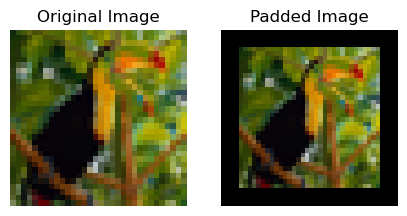

In [112]:
img = Image.open('img_002_SRF_2_LR.png')
img = img.resize((32,32),Image.BICUBIC)
img = np.asarray(img)
# normalize img
img = img/255.0
# zero pad image by adding 3 zeros to each side
img_pad = np.pad(img, ((4,4),(4,4),(0,0)), mode='constant')

fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img_pad)
axs[1].set_title('Padded Image')
axs[1].axis('off')

print("image shape:", img.shape, "padded image shape:", img_pad.shape)

In [113]:
# initialize kernel
k = np.random.randn(128*3*9*9).reshape((128,3,9,9))
C = toeplitz_mult_ch(k, (3,40,40))
print("the toeplitz matrix for 128x3x9x9 kernel shape: ", C.shape)
print("flattened padded image shape: ", img_pad.flatten().shape)

the toeplitz matrix for 128x3x9x9 kernel shape:  (131072, 4800)
flattened padded image shape:  (4800,)


In [114]:
# try everything in pytorch
C_torch = torch.FloatTensor(C).unsqueeze(0).transpose(-1,-2)
y = torch.FloatTensor(img_pad).permute(2,0,1).flatten()[None, :, None]
print("pytorch image shape:", y.shape)
print("pytorch toeplitz matrix shape:", C_torch.shape)
x = C_torch.transpose(-1,-2) @ y
print("state shape: ", x.shape)

# check correctness of convolution via toeplitz matrix
print(np.sum((x.numpy().reshape(1,128,32,32) - F.conv2d(y.view(1,3,40,40), torch.FloatTensor(k)).numpy())**2))

pytorch image shape: torch.Size([1, 4800, 1])
pytorch toeplitz matrix shape: torch.Size([1, 4800, 131072])
state shape:  torch.Size([1, 131072, 1])
2.6758417e-07


In [125]:
mu = 0.2
Cy = x.clone()
x_k = x.clone()
I_x = torch.eye(C_torch.shape[-2]).unsqueeze(0).unsqueeze(0)
loss_list = []
for i in range(2):
    W_inv = torch.div(torch.abs(x_k), mu)
    x_k = W_inv * Cy - (W_inv.transpose(-1,-2) * C_torch).transpose(-1,-2) @ \
                        torch.inverse(I_x+(C_torch * W_inv.transpose(-1,-2)) @ C_torch.transpose(-1,-2)) @ \
                        ((C_torch * W_inv.transpose(-1,-2)) @ Cy)
    loss = torch.norm(y - C_torch @ x_k).item()+mu * torch.norm(x_k,1).item()
    loss_list.append(loss)

In [126]:
print(loss_list)

[9.352375984191895, 0.5291255116462708]


the ratio of zero elements is 25.83%


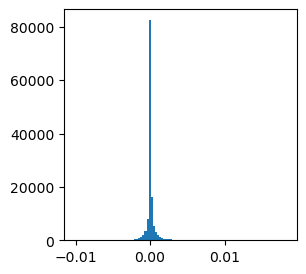

In [130]:
plt.figure(figsize=(3,3))
_ = plt.hist(x_k.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_k)<1e-5)/(np.prod(x_k.shape)))*100:.2f}%")
x_shrinkage = x_k.numpy().flatten().copy()

(-0.5, 31.5, 31.5, -0.5)

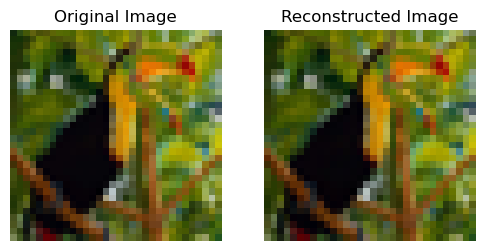

In [131]:
test_recon = (C_torch @ x_k).view(3,40,40).permute(1,2,0).numpy()

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(test_recon[4:-4,4:-4,:].clip(0,1))
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')